The demo uses LANGUAGE task data from a sample of 30 subjects in the Human Connectome Project (HCP) Young Adult dataset to showcase the processing pipeline. This includes first-level processing through to a variety of fROI-based analyses, such as effect size, spatial correlations and spatial overlap estimations.

The language localizer task in the HCP involves two conditions: a story condition, where participants listen to brief auditory stories followed by a comprehension question, and a math condition, where participants solve arithmetic problems. These tasks are designed to activate distinct regions of the brain, with the story condition engaging the language network and the math condition serving as a non-linguistic control. fMRI data collected during these tasks allow researchers to identify brain regions specifically involved in language processing.

# Prerequisites

Before running the demo locally, please configure your AWS credentials to access the HCP dataset. Follow these steps:

1. Refer to the [HCP wiki guide](https://wiki.humanconnectome.org/docs/How%20To%20Connect%20to%20Connectome%20Data%20via%20AWS.html) for instructions on obtaining AWS credentials for accessing the dataset.
    
2. Configure and store your credentials in the `~/.aws/credentials` file. You can find detailed instructions in the [AWS CLI user guide](https://docs.aws.amazon.com/cli/v1/userguide/cli-configure-files.html).

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
subjects1 = ['100206', '100307', '100408', '100610', '101006', '101107', 
    '101309', '101410', '101915', '102008', '102109', '102311', '102513', 
    '102614', '102715', '102816', '103010', '103111', '103212', '103414', 
    '103515', '103818', '104012', '104416', '104820', '105014', '105115', 
    '105216', '105620', '105923', '106016', '106319', '106521', '106824', 
    '107018', '107321', '107422', '107725', '108020', '108121', '108222', 
    '108323', '108525', '108828', '109123', '109325', '109830', '110007', 
    '110411', '110613']
subjects2 = ['111009', '111211', '111312', '111413', '111514', '111716', 
    '112112', '112314', '112516', '112920', '113215', '113316', '113619', 
    '113922', '114116', '114217', '114318', '114419', '114621', '114823']

In [3]:
from funROI.datasets import hcp
hcp.fetch_data("./data", task='LANGUAGE', subjects=subjects1+subjects2)

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x2aaab4845d30>>
Traceback (most recent call last):
  File "/storage/home/hcoda1/0/rgao76/.conda/envs/funROI/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


AttributeError: module 'funROI.datasets.hcp' has no attribute 'fetch_language_data'

# First Level Modeling

The first-level model in fMRI processing is designed to analyze individual subject data by modeling the relationship between task-related experimental conditions and the observed brain activity, by constructing a General Linear Model (GLM) for each voxel to estimate condition-specific effects and identify brain regions activated by the task.

The funROI toolbox wraps Nilearn's first-level modeling, supporting event-related and block designs, customizable hemodynamic response functions, confound regression, and statistical contrasts. Below, we demonstrate how to configure and run a first-level model using funROI.

In [4]:
import funROI
# funROI.set_bids_data_folder('./data/bids')
# funROI.set_bids_preprocessed_folder('./data/bids')
# funROI.set_bids_deriv_folder('./data/bids/derivatives')
# funROI.set_analysis_output_folder("./data/analysis")

funROI.set_bids_data_folder('/storage/home/hcoda1/0/rgao76/scratch/HCP/bids')
funROI.set_bids_preprocessed_folder('/storage/home/hcoda1/0/rgao76/scratch/HCP/bids') # using HCP preprocessed data
funROI.set_bids_deriv_folder('/storage/home/hcoda1/0/rgao76/scratch/HCP/bids/derivatives')
funROI.set_analysis_output_folder("./data/analysis")


In [ ]:
from funROI.first_level.nilearn import run_first_level
run_first_level(
    task = 'LANGUAGE',
    subjects = subjects1 + subjects2,
    space = 'MNINonLinear',
    contrasts = [
        ('story', {'story': 1}),
        ('math', {'math': 1}),
        ('story-math', {'story': 1, 'math': -1}),
    ],
    slice_time_ref = 0
)

# Generate Parcels for the Language System

In this part, we will demonstrate how to generate parcels for the language system using the 30-subject sample. We will focus on the story-math contrast to isolate regions of the brain involved in language processing. These group-level parcels will later serve as spatial constraints for defining subject-specific functional regions of interest.

In [ ]:
from funROI.analysis import ParcelsGenerator
parcels_generator = ParcelsGenerator(
    parcels_name="Language",
    smoothing_kernel_size=10,
    overlap_thr_vox=0.03,
    min_voxel_size=100,
    overlap_thr_roi=0.8
)
parcels_generator.add_subjects(
    subjects=subjects1,
    task="LANGUAGE",
    contrasts=["story-math"],
    p_threshold_type="none",
    p_threshold_value=0.05,
)
parcels = parcels_generator.run()

Let's take a look at the parcels generated using a sample of 30 subjects for the language system.
The code snippet below plots the parcels on the brain surface for better visualization:

In [5]:
from nilearn.image import load_img
parcels = '/storage/home/hcoda1/0/rgao76/funROI-HCP-Analysis/Data/parcels/task-LANGUAGE_contrast-story-math_smooth-10_vox-0.03_sz-50_i-0/task-LANGUAGE_contrast-story-math_smooth-10_vox-0.03_sz-50_i-0_0000.nii.gz'
parcels = load_img(parcels)

In [5]:
from nilearn.plotting import plot_surf_roi
from nilearn.datasets import fetch_surf_fsaverage
from nilearn.surface import vol_to_surf
fsaverage = fetch_surf_fsaverage('fsaverage5')

def plot_surf(data, label=None, views=["lateral", "medial"], hemispheres=["left", "right"]):
    surf_data = {
        "left": vol_to_surf(data, fsaverage.pial_left, interpolation='nearest', radius=0),
        "right": vol_to_surf(data, fsaverage.pial_right, interpolation='nearest', radius=0),
    }

    for hemi in hemispheres:
        for view in views:
            title = f"{hemi.capitalize()} Hemisphere - {view.capitalize()} View"
            if label:
                title = f"{label}: {title}"
            plot_surf_roi(
                surf_mesh=getattr(fsaverage, f"pial_{hemi}"),
                roi_map=surf_data[hemi],
                hemi=hemi,
                view=view,
                bg_on_data=True,
                bg_map=getattr(fsaverage, f"sulc_{hemi}"),
                darkness=0.5,
                cmap="gist_rainbow",
                avg_method='max',
                title=title
            )
            if label:
                fig_name = f"images/{label}_{hemi}_{view}_20250211.png"
            else:
                fig_name = f"images/parcels_{hemi}_{view}_20250211.png"
            plt.savefig(fig_name)

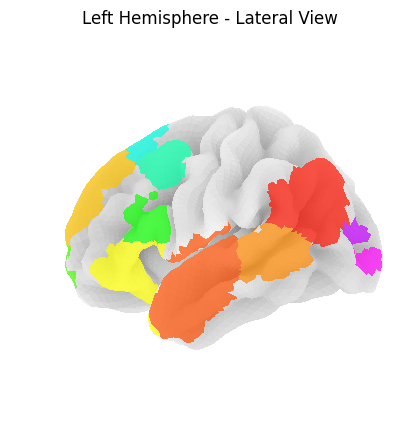

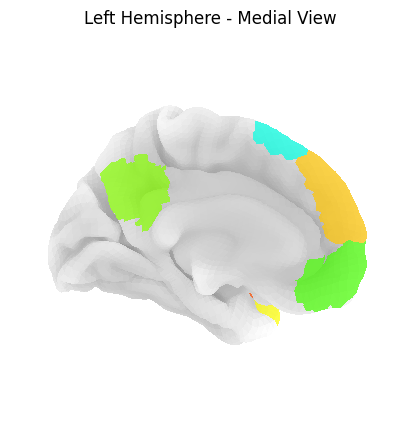

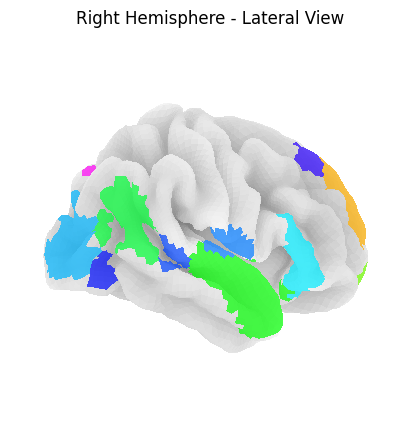

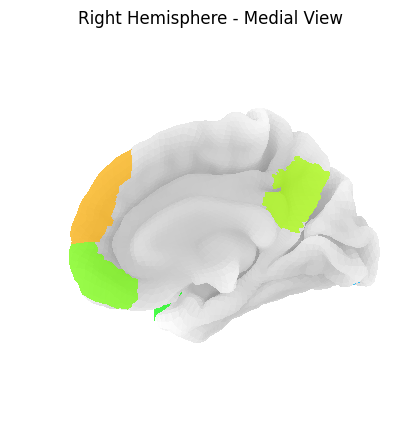

In [18]:


plot_surf(parcels)

Rendered results:

<img src="images/parcels_left_lateral.png" width=300 />
<img src="images/parcels_right_lateral.png" width=300 />
<br>
<img src="images/parcels_left_medial.png" width=300 />
<img src="images/parcels_right_medial.png" width=300 />

# Define Individual fROIs

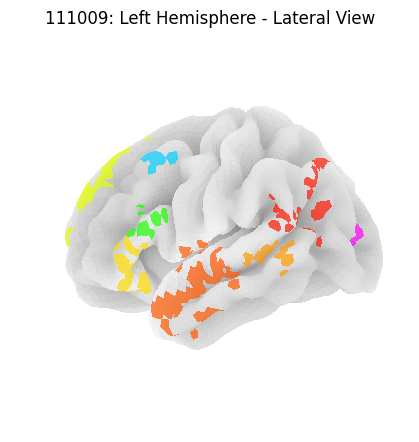

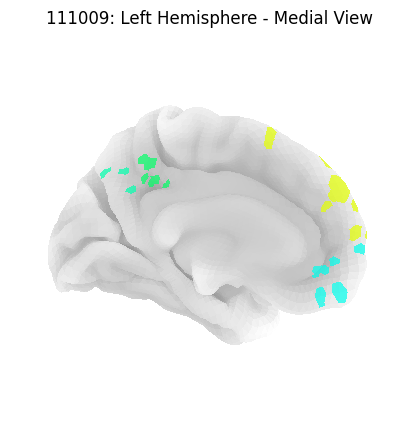

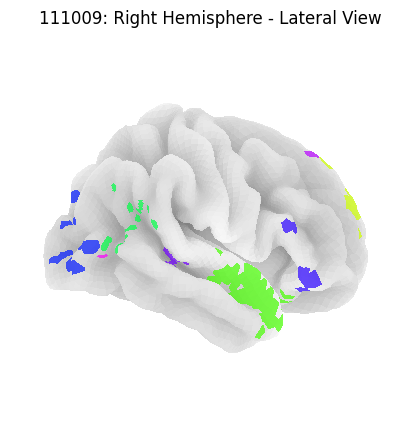

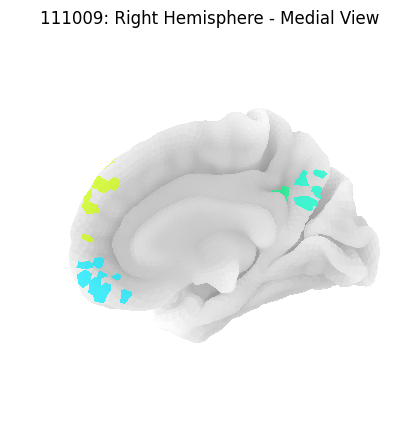

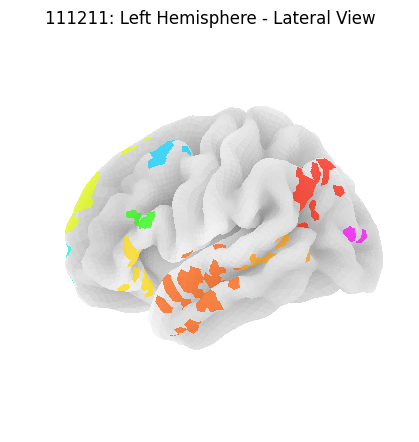

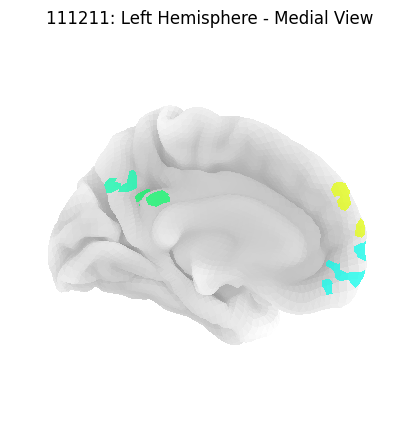

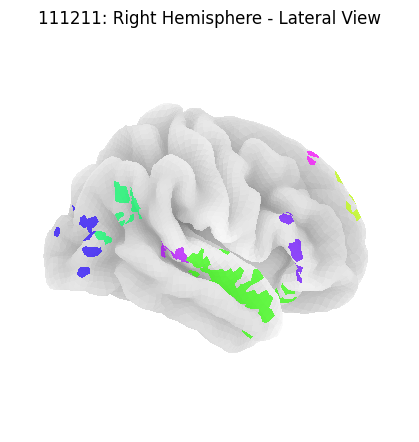

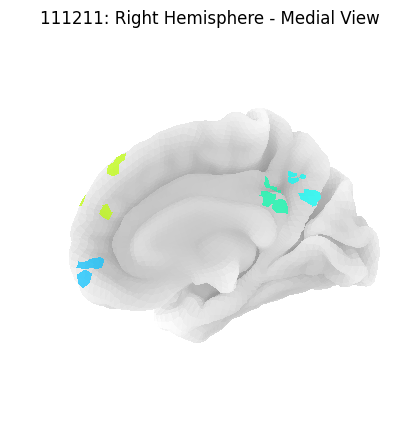

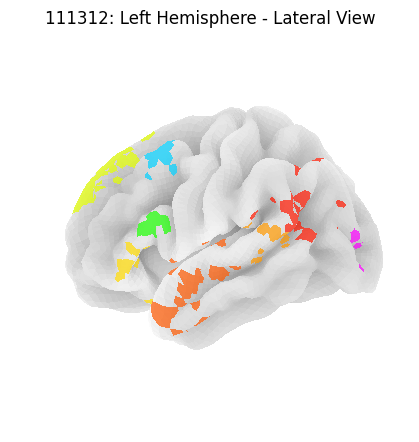

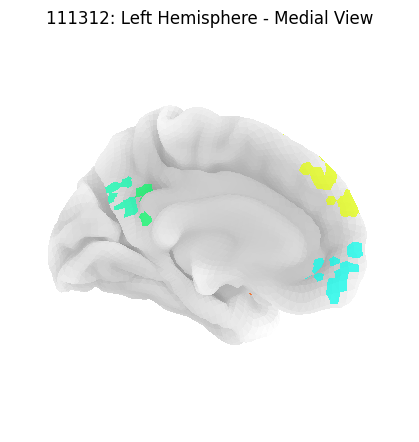

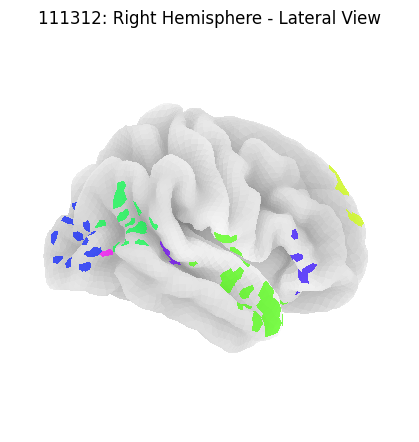

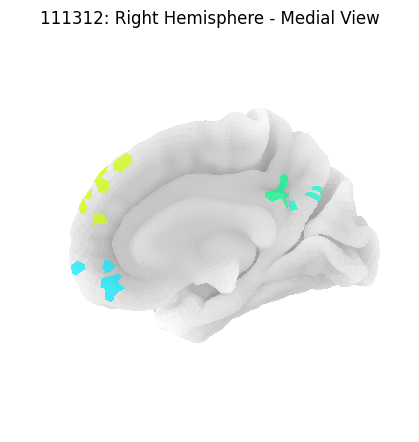

In [19]:
from funROI.analysis import FROIGenerator
froi = funROI.FROIConfig(
    task="LANGUAGE",
    contrasts=["story-math"],
    threshold_type="percent",
    threshold_value=0.1,
    # parcels="./data/analysis/parcels/Language/Language_0000.nii.gz",
    parcels='/storage/home/hcoda1/0/rgao76/funROI-HCP-Analysis/Data/parcels/task-LANGUAGE_contrast-story-math_smooth-10_vox-0.03_sz-250_i-0/task-LANGUAGE_contrast-story-math_smooth-10_vox-0.03_sz-250_i-0_0000.nii.gz'
)
froi_generator = FROIGenerator(subjects2[:3], froi)
froi_imgs = froi_generator.run()
for subject_label, froi_img in froi_imgs:
    plot_surf(froi_img, views=["lateral", "medial"], label=subject_label)

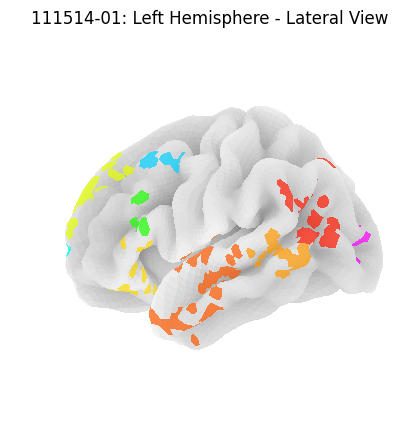

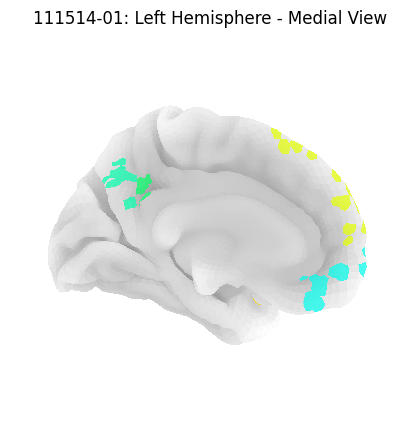

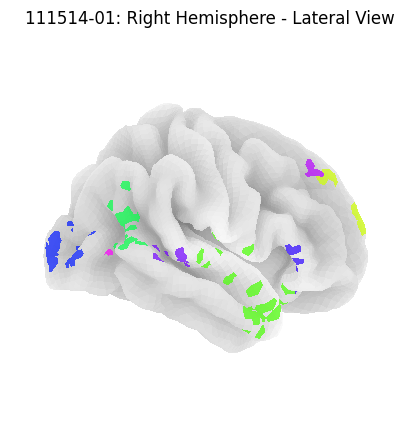

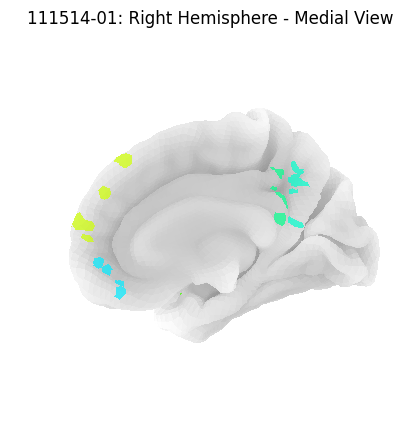

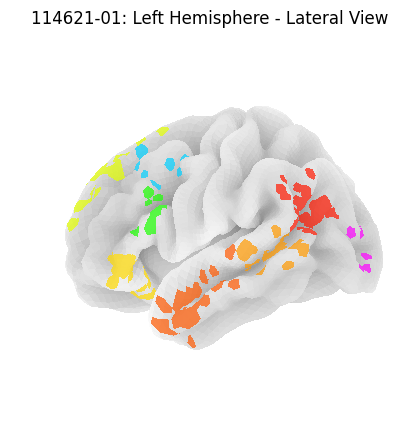

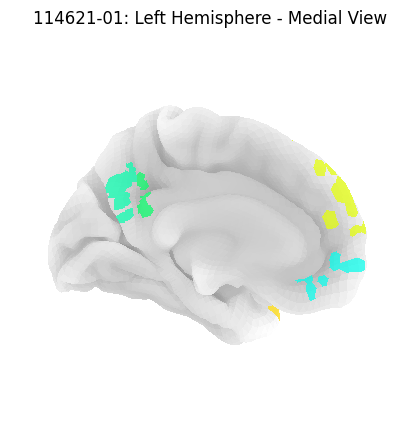

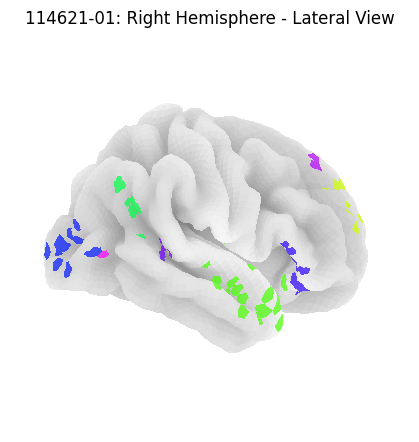

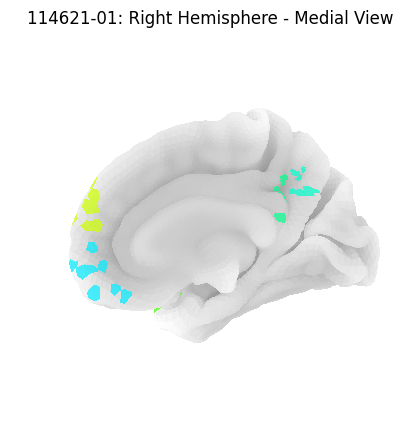

In [25]:
from funROI.analysis import FROIGenerator
froi = funROI.FROIConfig(
    task="LANGUAGE",
    contrasts=["story-math"],
    threshold_type="percent",
    threshold_value=0.1,
    # parcels="./data/analysis/parcels/Language/Language_0000.nii.gz",
    parcels='/storage/home/hcoda1/0/rgao76/funROI-HCP-Analysis/Data/parcels/task-LANGUAGE_contrast-story-math_smooth-10_vox-0.03_sz-250_i-0/task-LANGUAGE_contrast-story-math_smooth-10_vox-0.03_sz-250_i-0_0000.nii.gz'
)
froi_generator = FROIGenerator(['111514', '114621'], froi, run_label='01')
froi_imgs = froi_generator.run()
for subject_label, froi_img in froi_imgs:
    plot_surf(froi_img, views=["lateral", "medial"], label=subject_label+'-01')

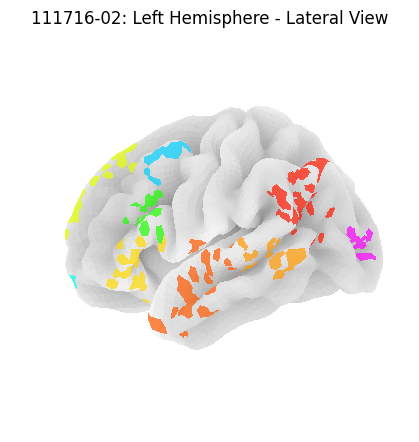

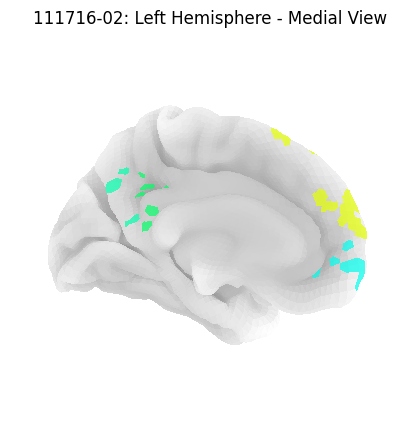

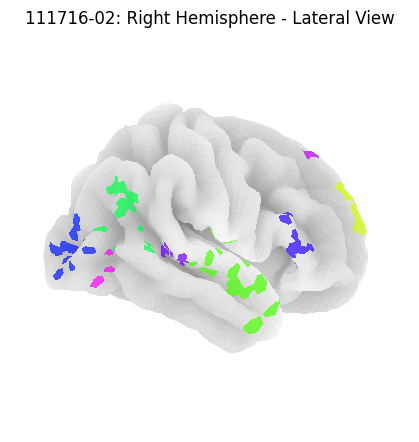

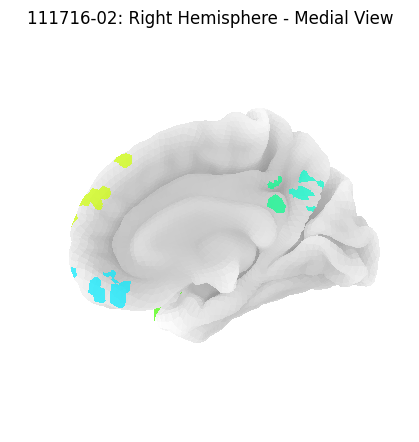

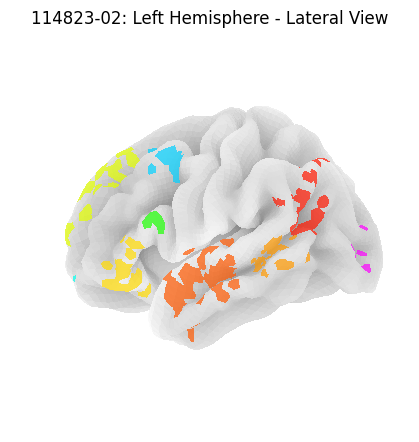

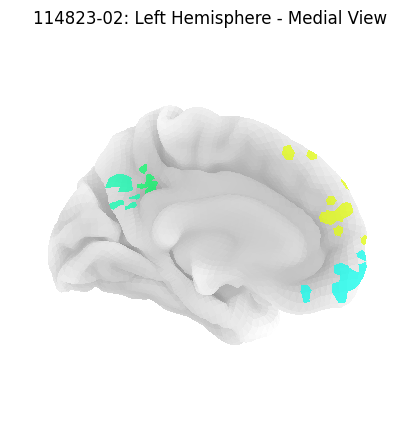

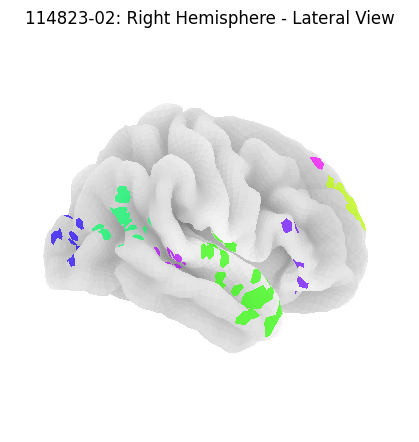

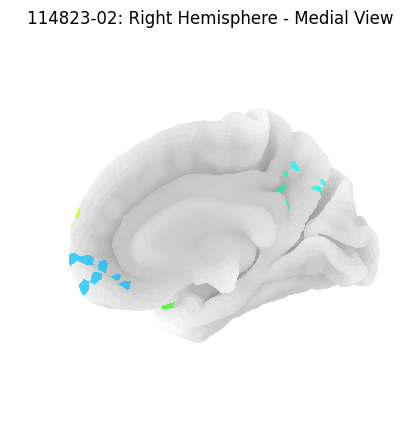

In [26]:
from funROI.analysis import FROIGenerator
froi = funROI.FROIConfig(
    task="LANGUAGE",
    contrasts=["story-math"],
    threshold_type="percent",
    threshold_value=0.1,
    # parcels="./data/analysis/parcels/Language/Language_0000.nii.gz",
    parcels='/storage/home/hcoda1/0/rgao76/funROI-HCP-Analysis/Data/parcels/task-LANGUAGE_contrast-story-math_smooth-10_vox-0.03_sz-250_i-0/task-LANGUAGE_contrast-story-math_smooth-10_vox-0.03_sz-250_i-0_0000.nii.gz'
)
froi_generator = FROIGenerator(['111716', '114823'], froi, run_label='02')
froi_imgs = froi_generator.run()
for subject_label, froi_img in froi_imgs:
    plot_surf(froi_img, views=["lateral", "medial"], label=subject_label+'-02')

In [23]:
subjects2[:3]

['111009', '111211', '111312']

# Analysis: Effect Sizes

Effect size estimation is a critical step in fROI analysis, as it provides a quantitative measure of the strength of the neural response to specific contrasts or conditions.

In this section, we will demonstrate how to estimate effect sizes for story and math conditions within subjects' language fROIs. We will use the language system parcel generated in the previous section. For each parcel, the language fROI is defined as the top 10% of voxels responding to the story-math contrast. The effect sizes of the language system will be evaluated in the defined fROIs.

The analyses below will be done using an heldout set of 10 subjects independent from subjects for generating language parcels.

In [6]:
from funROI.analysis import EffectEstimator
froi = funROI.FROIConfig(
    task="LANGUAGE",
    contrasts=["story-math"],
    threshold_type="percent",
    threshold_value=0.1,
    # parcels="./data/analysis/parcels/Language/Language_0000.nii.gz",
    parcels='/storage/home/hcoda1/0/rgao76/funROI-HCP-Analysis/Data/parcels/task-LANGUAGE_contrast-story-math_smooth-10_vox-0.03_sz-250_i-0/task-LANGUAGE_contrast-story-math_smooth-10_vox-0.03_sz-250_i-0_0000.nii.gz'
)
effect_estimator = EffectEstimator(subjects=subjects2, froi=froi)
df_summary, df_detail = effect_estimator.run(
    task="LANGUAGE", effects=["story", "math"])

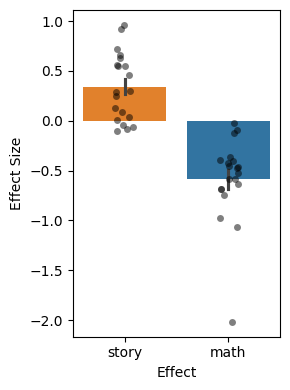

In [10]:
plt.figure(figsize=(3,4))
data = df_summary.groupby(["subject", "effect"]).mean().reset_index()
sns.barplot(data=data, y="size", x="effect", hue="effect", errorbar="se", order=["story", "math"])
sns.stripplot(data=data, y="size", x="effect", dodge=False, alpha=0.5, jitter=True, order=["story", "math"], color='black')
plt.ylabel("Effect Size")
plt.xlabel("Effect")
plt.tight_layout()
plt.savefig("images/effect_size_20250211.png", dpi=300)

As we examine the effect sizes for the subjects' language system, we observe the expected higher responsiveness to story compared to math. This confirms the validity of our approach. 

<img src="images/effect_size.png" width=300 height=500 />

More interesting questions can be explored by applying the language localizer to evaluate response magnitude for other conditions in other task runs!

# Analysis: Spatial Correlation Across Conditions

Spatial correlation provides a valuable metric for assessing the similarity of activation patterns across different conditions or runs. This analysis can be performed on parcels or fROIs, allowing researchers to evaluate the consistency of functional responses in specific regions of the brain.

In the context of the HCP dataset, which includes only two runs for the language localizer task, we cannot fully utilize fROIs for spatial correlation due to the lack of sufficient runs (at least three are required). However, we can demonstrate spatial correlation between the story and math conditions using the previously defined parcels. When datasets with more runs are available, this approach can be extended to fROIs for a more refined analysis of spatial similarity.

In [11]:
from funROI.analysis import SpatialCorrelationEstimator
spcorr_estimator = SpatialCorrelationEstimator(
    subjects=subjects2,
    # froi="./data/analysis/parcels/Language/Language_0000.nii.gz"
    froi='/storage/home/hcoda1/0/rgao76/funROI-HCP-Analysis/Data/parcels/task-LANGUAGE_contrast-story-math_smooth-10_vox-0.03_sz-250_i-0/task-LANGUAGE_contrast-story-math_smooth-10_vox-0.03_sz-250_i-0_0000.nii.gz'
)
df_math, _ = spcorr_estimator.run(
    task1='LANGUAGE', effect1='math', task2='LANGUAGE', effect2='math',
)
df_story, _ = spcorr_estimator.run(
    task1='LANGUAGE', effect1='story', task2='LANGUAGE', effect2='story',
)
df_between, _ = spcorr_estimator.run(
    task1='LANGUAGE', effect1='story', task2='LANGUAGE', effect2='math',
)

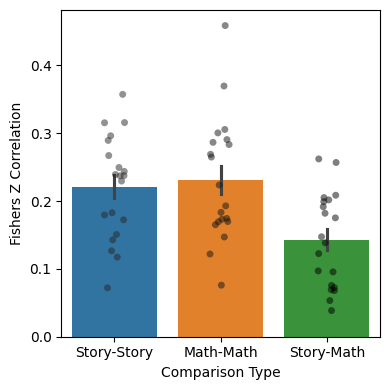

In [13]:
df_math['Type'] = 'Math-Math'
df_story['Type'] = 'Story-Story'
df_between['Type'] = 'Story-Math'
data = pd.concat(
    [df_between, df_math, df_story]
).groupby(["subject", "Type"]).mean().reset_index()

plt.figure(figsize=(4,4))
sns.barplot(data=data, y="fisher_z", x="Type", hue="Type", errorbar="se", hue_order=["Story-Story",  "Math-Math", "Story-Math"], order=["Story-Story",  "Math-Math", "Story-Math"])
sns.stripplot(data=data, y="fisher_z", x="Type", hue="Type", dodge=False, alpha=0.5, jitter=True, hue_order=["Story-Story",  "Math-Math", "Story-Math"], order=["Story-Story",  "Math-Math", "Story-Math"], color='black')
plt.ylabel("Fishers Z Correlation")
plt.xlabel("Comparison Type")
plt.tight_layout()
plt.savefig('images/spatial_correlation_20250211.png', dpi=300)

Rendered results:

<img src="images/spatial_correlation.png" width=500 height=500 />

# Analysis: Overlap Between fROIs

Assessing the spatial overlap between parcels or fROIs can be useful in various ways, guiding comparisons across tasks and conditions. In this section, we showcase an example of computing the degree of overlap between the language system defined using the localizer, as stated above (10% top voxels), across subjects and within subjects using different runs.

In [14]:
from funROI.analysis import OverlapEstimator
overlap_estimator = OverlapEstimator()

froi = funROI.FROIConfig(
    task="LANGUAGE",
    contrasts=["story-math"],
    threshold_type="percent",
    threshold_value=0.1,
    # parcels="./data/analysis/parcels/Language/Language_0000.nii.gz",
    parcels='/storage/home/hcoda1/0/rgao76/funROI-HCP-Analysis/Data/parcels/task-LANGUAGE_contrast-story-math_smooth-10_vox-0.03_sz-250_i-0/task-LANGUAGE_contrast-story-math_smooth-10_vox-0.03_sz-250_i-0_0000.nii.gz'
)

data = []
for i, subject1 in enumerate(subjects2):
    df, _ = overlap_estimator.run(
        froi1=froi, froi2=froi, subject1=subject1, subject2=subject1, run1='01', run2='02'
    )
    data.append(df[df['froi1'] == df['froi2']])

    subject2 = subjects2[(i+1) % len(subjects2)]
    df, _ = overlap_estimator.run(
        froi1=froi, froi2=froi, subject1=subject1, subject2=subject2, run1='01', run2='02'
    )
    data.append(df[df['froi1'] == df['froi2']])

data = pd.concat(data)

In [10]:
print(overlap_estimator.run1)

None


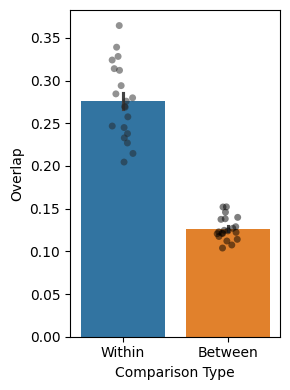

In [16]:
data.loc[data['subject1'] == data['subject2'], 'Type'] = 'Within'
data.loc[data['subject1'] != data['subject2'], 'Type'] = 'Between'
data_mean = data.groupby(["subject1", "subject2", "Type"]).mean().reset_index()
plt.figure(figsize=(3,4))
sns.barplot(data=data_mean, y="overlap", x="Type", hue="Type", errorbar="se")
sns.stripplot(data=data_mean, y="overlap", x="Type", hue="Type", dodge=False, alpha=0.5, jitter=True, color='black')
plt.ylabel("Overlap")
plt.xlabel("Comparison Type")
plt.tight_layout()
plt.savefig('images/overlap_20250211.png', dpi=300)

The results visualized below illustrate the spatial overlap results:

<img src="images/overlap.png" width=300 height=500 />

They demonstrate that the within-subject definitions are more consistent compared to across-subject definitions!

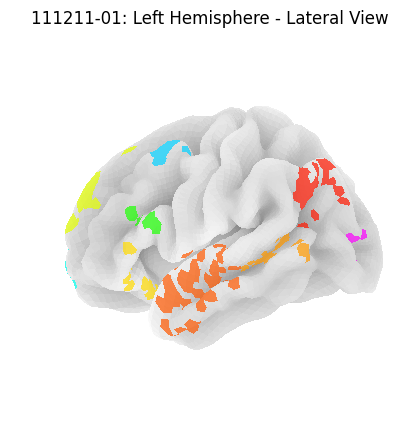

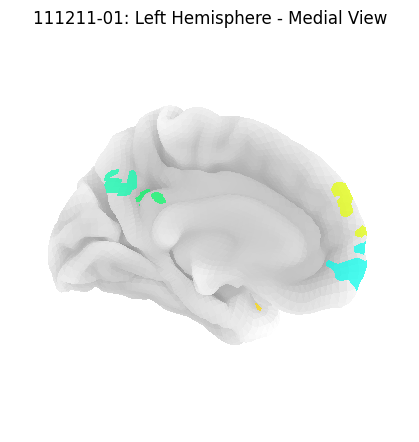

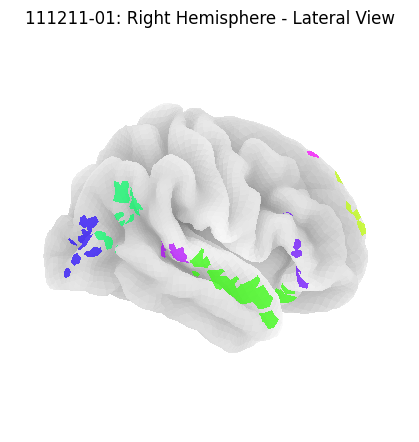

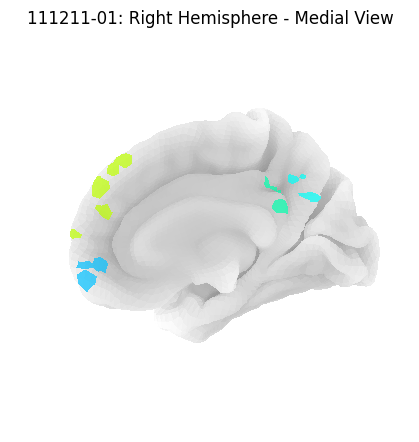

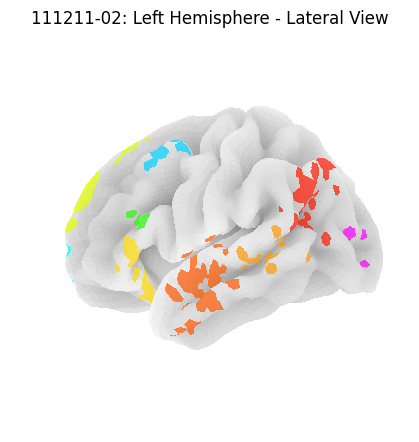

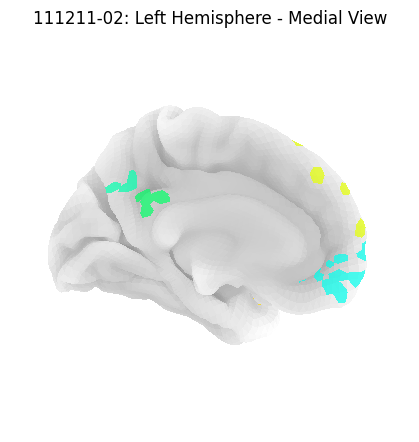

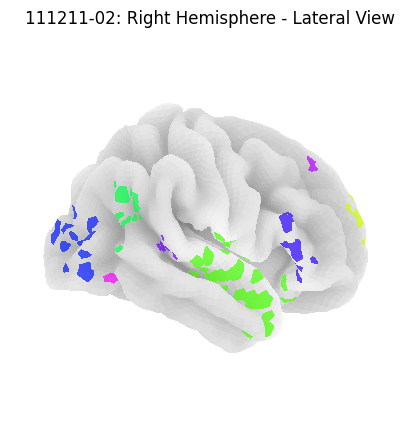

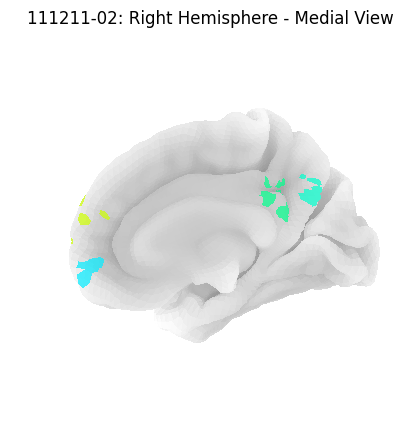

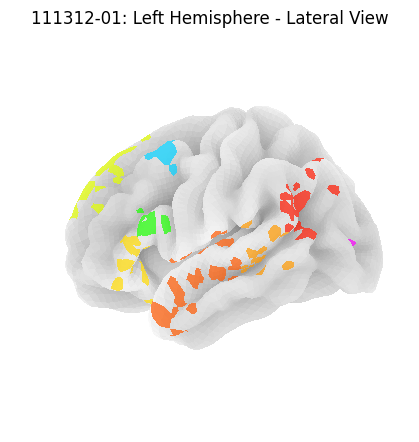

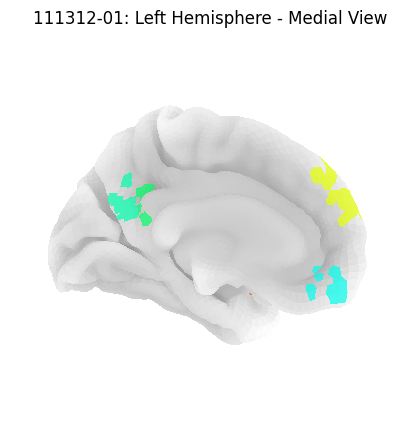

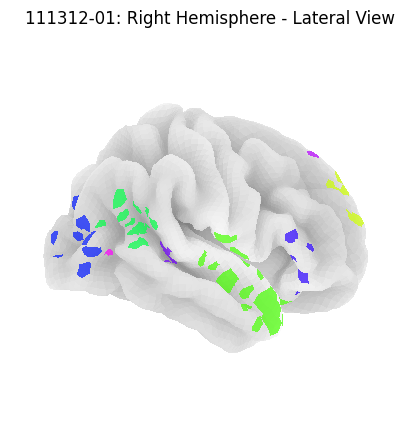

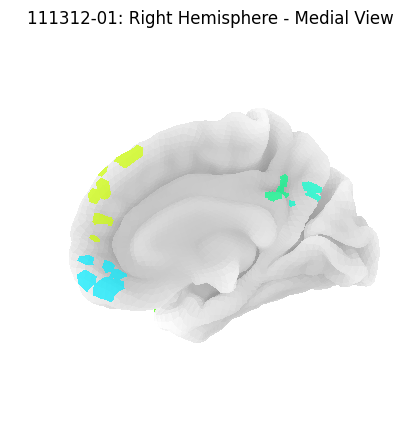

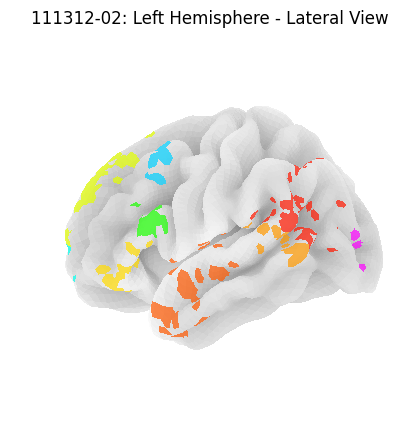

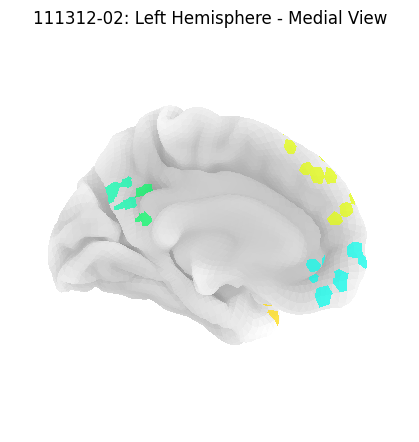

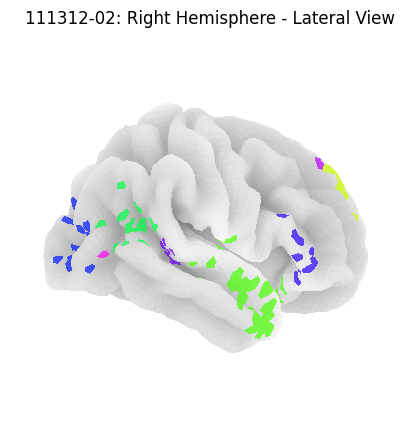

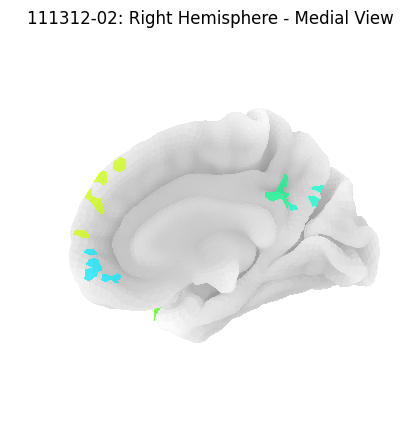

In [14]:
from funROI.analysis import FROIGenerator
for subject, run in zip(['111211', '111211', '111312', '111312'], 
                        ['01', '02', '01', '02']):
    froi_generator = FROIGenerator([subject], froi, run_label=run)
    froi_imgs = froi_generator.run()
    subject_label, froi_img = froi_imgs[0]
    plot_surf(froi_img, views=["lateral", "medial"], label=subject_label+'-'+run)

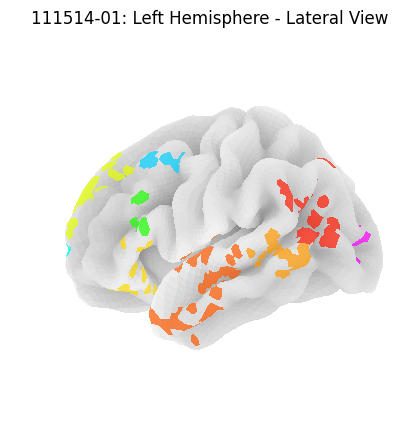

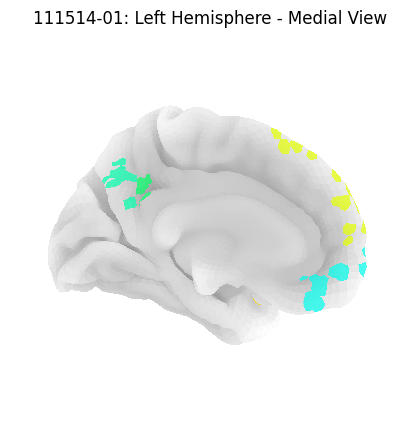

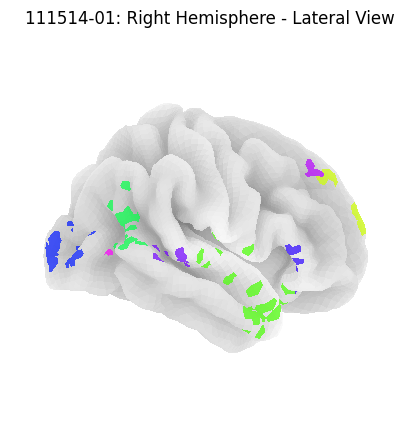

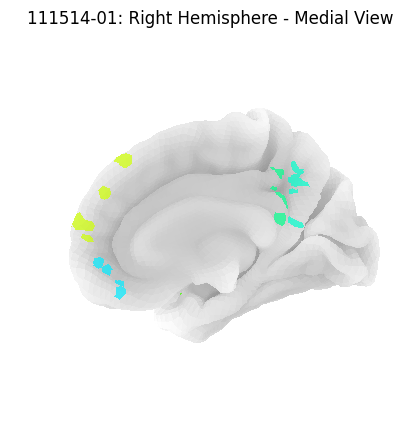

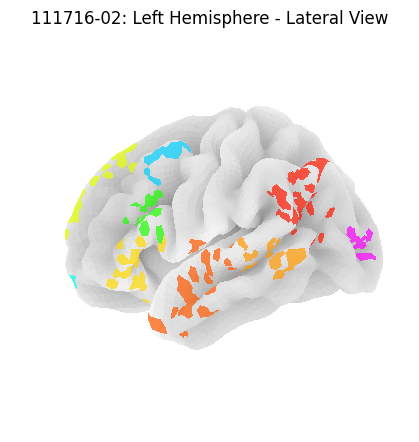

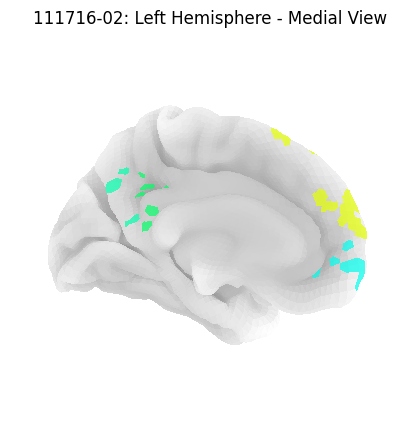

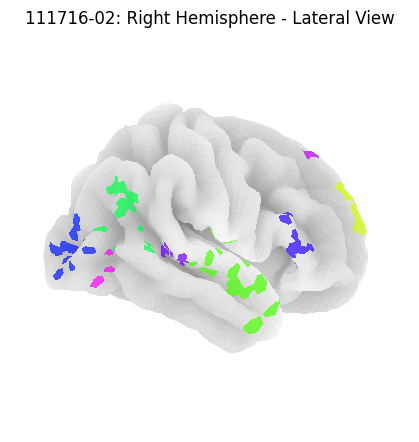

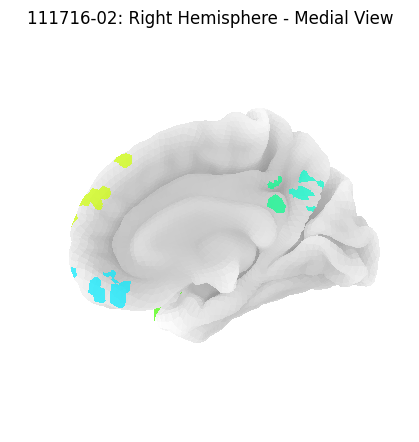

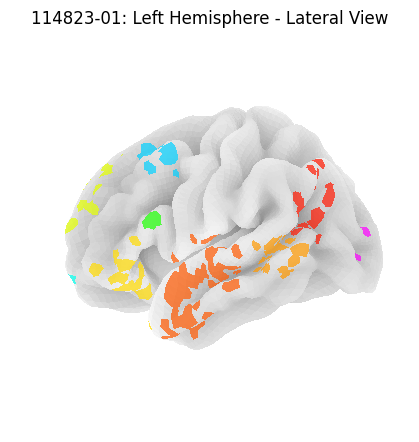

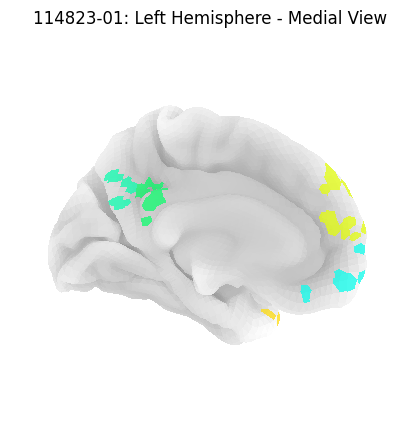

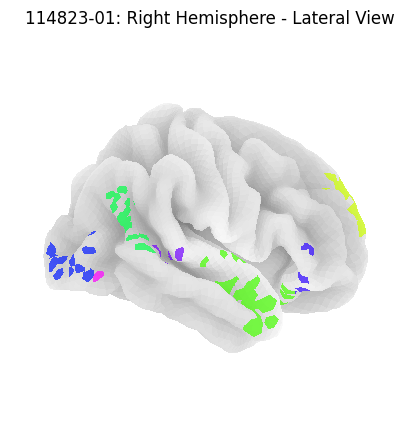

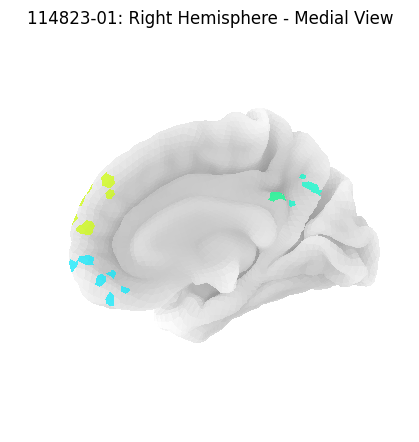

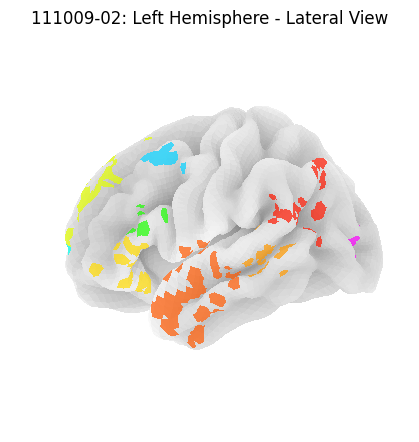

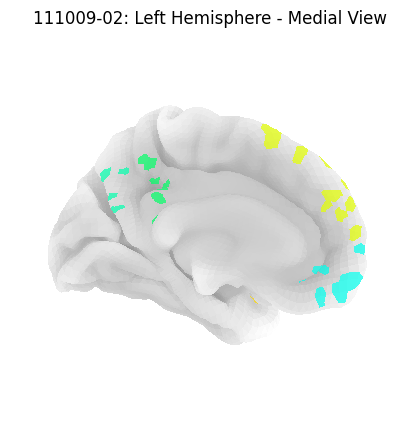

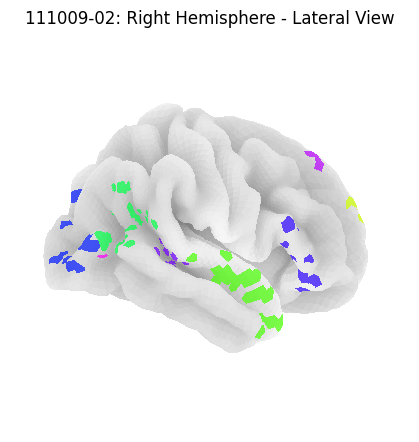

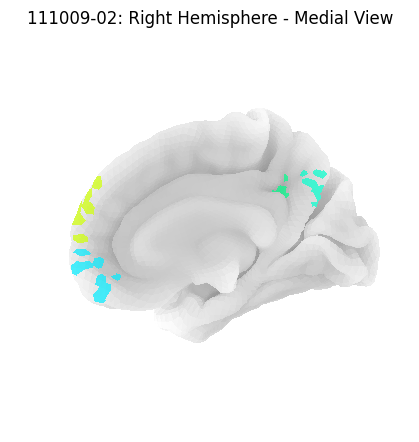

In [15]:
for subject, run in zip(['111514', '111716', '114823', '111009'], 
                        ['01', '02', '01', '02']):
    froi_generator = FROIGenerator([subject], froi, run_label=run)
    froi_imgs = froi_generator.run()
    subject_label, froi_img = froi_imgs[0]
    plot_surf(froi_img, views=["lateral", "medial"], label=subject_label+'-'+run)